 
# Jump Diffusion Model


In [1]:
## LOAD LIBRARIES
import os 
import sys
import time
import math

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns


%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

## Define Model Components
I split the function definition by the standard Diffusion and Jump Process

## Diffusion 
Standard Gauss-Weiner process:

* Instantaneous part of the unanticipated return --- due to the normal price vibrations (i.e if Lambda = 0)

In [2]:
def generate_asset_price(S0,sigma,mu,T,Nsims,KL):
    """ Standard difussion --- Brownian motion for asset price 
        
        Parameters
        ==========
        
        S0 (float): Initial Stock Price
        sigma (float) : instantaneous variance of the return
        mu (float) : instaneous expected return of S
        
        T (float) : Period over which process occurs
        Nsims (int) : Number of MC simulations
        KL (float) : k is the expectation operator over the random variable Y,KL = Lambda*k, if Lambda = 0, then K = 0
    
        References
        ==========
        http://www.people.hbs.edu/rmerton/optionpricingwhenunderlingstock.pdf
        https://www.lpsm.paris/pageperso/tankov/tankov_voltchkova.pdf
    
    """
    return S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.normal(0,1.0,Nsims) - T*KL)

## Jump Process
Define a Compound poisson process, with an impulse function producing a finite jump from S to SY
i.e (Y-1) is the jump should a poisson event occur

In [3]:
def jump_process(Lambda,a,b,T,Nsteps,Nsims):
    
    """ Simulate compound poisson process with Lambda & Lognormal Dist 
        
        Parameters
        ==========
        
        Lambda (float): Intensity of Poisson Process i.e. Num expected jumps in T period
        a (float) : mu of underlying normal distribution
        b (float) : variance of underlying normal distribution (This should be scaled for t)
        
        T (float) : Period over which Jump process occurs
        Nsteps (int) : Number of increments 
        Nsims (int) : Number of MC simulations 
        
        Returns
        ========
        compoind poission process (list) : 1 d array of the resultant 
            Y(u) = I if II = 0; Y(/r) = fly _, Y, for n 2 I
    
        References
        ==========
        http://www.people.hbs.edu/rmerton/optionpricingwhenunderlingstock.pdf
        https://www.lpsm.paris/pageperso/tankov/tankov_voltchkova.pdf
        
    """
    delta_t = T/Nsteps
    num_jumps=np.random.poisson(Lambda*delta_t, size=Nsims)
    delta_jumps = [np.random.lognormal(a,b,jumps) if jumps > 0 else 1 for jumps in num_jumps ]
    """ Return  Y(n) as per Merton 1976 Pg 129 --- (3)"""
    return [np.prod(x) for x in delta_jumps]

## Main Run

In [4]:
# USER INPUT
S0=100
alpha=0.05
Nsims = 1000
Nsteps=252
sigma=0.3
mu=0
T=1.0
Lambda=2.0#/Nsteps
b=1.0 #/np.sqrt(Nsteps) #Percentage Jump
a=0.0

def jump_diffusion_simulation(mu=mu,sigma=sigma,T=T,S0=S0,a=a,b=b,
                              Lambda=Lambda,Nsteps=Nsteps,Nsims=Nsims,hide=False):
    """ Simulate stock price accounting for large jumps in short periods i.e. 'jump stochastic process'
    
    Parameters
    ==========
    
    S0 (float): Initial Stock Price
    sigma (float) : instantaneous variance of the return
    mu (float) : instaneous expected return of S
 
    Lambda (float): Intensity of Poisson Process i.e. Num expected jumps in T period
    a (float) : mu of underlying normal distribution
    b (float) : variance of underlying normal distribution (This should be scaled for t)

    T (float) : Period over which Jump process occurs
    Nsteps (int) : Number of increments 
    Nsims (int) : Number of MC simulations 

    
    """

    tic=time.time()
           
    delta_t = T/Nsteps
    b = b*np.sqrt(delta_t)
    KL = Lambda*(np.exp(b**2/2) - 1)

    simulated_paths = np.ones((Nsims,Nsteps+1))
    simulated_paths[:,0] = S0
    
    mean_Y = np.exp(a + 0.5*((b)**2))
    variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)

    M = S0 * np.exp(mu*T + Lambda*T*(mean_Y-1))
    V = S0**2 * (np.exp((2*mu + sigma**2)*T \
        + Lambda*T*(variance_Y + mean_Y**2 - 1)) \
        - np.exp(2*mu*T + 2*Lambda*T*(mean_Y - 1)))

    for i in range(Nsteps):
        simulated_paths[:,i+1] = generate_asset_price(simulated_paths[:,i],sigma,mu,delta_t,Nsims,KL)*\
        jump_process(Lambda=Lambda,a=a,b=b,T=T,Nsteps=Nsteps,Nsims=Nsims)
    toc = time.time()
    elapsed_time = toc - tic
    if not hide:
        print('Total running time: {:.2f} ms'.format(elapsed_time*1000))
        print('K (expected Jump) {:>.2f}%'.format((mean_Y-1.0)*100))
    return M,V,simulated_paths

### Simulate and visualise a Jump-Diffusion process

Using 1000 simulations

Total running time: 1186.00 ms
K (expected Jump) 0.20%


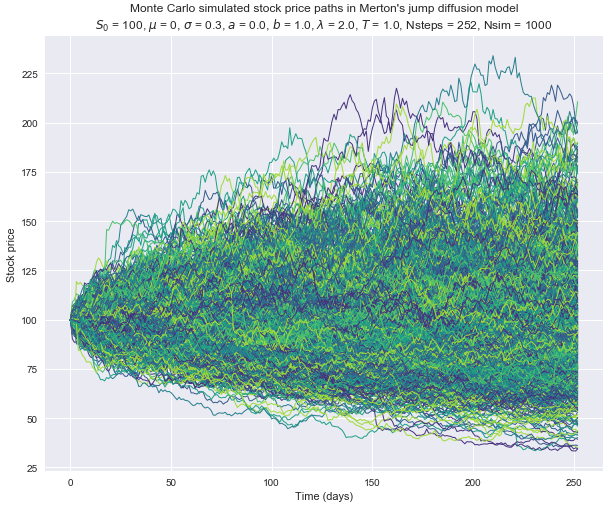

Total running time: 172294529.00 ms
Mean                  99.6255
Variance             949.2895
Standard deviation    30.8105


In [312]:
M,V, simulated_paths = jump_diffusion_simulation()
final_prices = simulated_paths[:,-1]

# Compute mean, variance, standard deviation, skewness, excess kurtosis
mean_S = np.mean(final_prices)
var_S = np.var(final_prices)
std_S = np.std(final_prices)
skew_S = stats.skew(final_prices)
kurt_S = stats.kurtosis(final_prices)

# Choose palette, figure size, and define figure axes
sns.set(palette='viridis')
plt.figure(figsize=(10,8))
ax = plt.axes()

# Generate t, the time variable on the abscissae
t = np.linspace(0, T, Nsteps+1) * Nsteps

# Plot the Monte Carlo simulated stock price paths
jump_diffusion = ax.plot(t, simulated_paths.transpose());

# Make drawn paths thinner by decreasing line width
plt.setp(jump_diffusion, linewidth=1);

# Set title (LaTeX notation) and x- and y- labels
ax.set(title="Monte Carlo simulated stock price paths in Merton's jump \
diffusion model\n$S_0$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, \
$\lambda$ = {}, $T$ = {}, Nsteps = {}, Nsim = {}"\
       .format(S0, mu, sigma, a,b, Lambda, T, Nsteps, Nsims), \
       xlabel='Time (days)', ylabel='Stock price')
#ax.set_yscale('log')
# Display figure in a Python environment
plt.show()

# Time and print the elapsed time
toc = time.time()
elapsed_time = toc - tic
print('Total running time: {:.2f} ms'.format(elapsed_time*1000))
print('Mean {:>24.4f}'.format(mean_S))
print('Variance {:>20.4f}'.format(var_S))
print('Standard deviation {:>10.4f}'.format(std_S))

### Varying number of simulations
sims [1000, 100,000]

In [313]:
num_sims = [1000,10000,20000,40000,80000,100000]
def run_multiple_MC_sims(num_sims=num_sims):
    for Nsim in num_sims:
        print("Simulation Run with Number Sims: {}".format(Nsim))
        print("===============================")
        np.random.seed(0)
        M,V, simulated_paths = jump_diffusion_simulation(Nsims=Nsim)
        final_prices = simulated_paths[:,-1]
        # Compute mean, variance, standard deviation, skewness, excess kurtosis
        mean_S= np.mean(final_prices)
        var_S = np.var(final_prices)
        std_S = np.std(final_prices)
        skew_S = stats.skew(final_prices)
        kurt_S = stats.kurtosis(final_prices)

        # Calculate confidence interval for the mean
        ci_low = mean_S - std_S/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)
        ci_high = mean_S + std_S/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)
        # Print statistics, align results
        print("Merton's Jump Diffusion Model")
        print('-----------------------------')
        print('Theoretical Moments')
        print('-----------------------------')
        print('Mean (M){:>21.4f}'.format(M))
        print('Variance (V){:>17.4f}'.format(V))
        print('\nMonte Carlo Estimates')
        print('-----------------------------')
        print('Mean {:>24.4f}'.format(mean_S))
        print('Variance {:>20.4f}'.format(var_S))
        print('Standard deviation {:>10.4f}'.format(std_S))
        print('Skewness {:>20.4f}'.format(skew_S))
        print('Excess kurtosis {:>13.4f}'.format(kurt_S))
        print('\nConfidence interval, Mean')
        print('-----------------------------')
        print('Alpha {:>23.2f}'.format(alpha))
        print('Lower bound {:>17.4f}'.format(ci_low))
        print('Upper bound {:>17.4f}'.format(ci_high))
        print("========END RUN========")
        print("\n")
run_multiple_MC_sims()

Simulation Run with Number Sims: 1000
Total running time: 1215.00 ms
K (expected Jump) 0.20%
Merton's Jump Diffusion Model
-----------------------------
Theoretical Moments
-----------------------------
Mean (M)             100.3980
Variance (V)        1037.7489

Monte Carlo Estimates
-----------------------------
Mean                 100.7700
Variance            1023.6187
Standard deviation    31.9940
Skewness               0.8689
Excess kurtosis        1.1433

Confidence interval, Mean
-----------------------------
Alpha                    0.05
Lower bound           98.7870
Upper bound          102.7530
========END RUN========


Simulation Run with Number Sims: 10000
Total running time: 11998.00 ms
K (expected Jump) 0.20%
Merton's Jump Diffusion Model
-----------------------------
Theoretical Moments
-----------------------------
Mean (M)             100.3980
Variance (V)        1037.7489

Monte Carlo Estimates
-----------------------------
Mean                  99.4608
Variance     

### Price a call option
Analyse convergence of price for increasing simulations

In [314]:
num_sims = [1000,10000,20000,40000,80000,100000]
def price_call_option_multiple_MC_sims(num_sims=num_sims,K=100):
    for Nsim in num_sims:
        print("Simulation Run with Number Sims: {}".format(Nsim))
        print("===============================")
        np.random.seed(0)
        M,V, simulated_paths = jump_diffusion_simulation(Nsims=Nsim)
        final_prices = simulated_paths[:,-1]
        A_t = [max([0,x-K]) for x in final_prices]
        # Compute mean, variance, standard deviation, skewness, excess kurtosis
        mean_At= np.mean(A_t)
        var_At = np.var(A_t)
        std_At = np.std(A_t)
        # Calculate confidence interval for the mean
        ci_low = mean_At - std_At/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)
        ci_high = mean_At + std_At/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)
        print('\nMonte Carlo Estimates')
        print('-----------------------------')
        print('Mean {:>24.4f}'.format(mean_At))
        print('Variance {:>20.4f}'.format(var_At))
        print('Standard deviation {:>10.4f}'.format(std_At))
        print('\nConfidence interval, Mean')
        print('-----------------------------')
        print('Alpha {:>23.2f}'.format(alpha))
        print('Lower bound {:>17.4f}'.format(ci_low))
        print('Upper bound {:>17.4f}'.format(ci_high))
        print("========END RUN========")
        print("\n")
price_call_option_multiple_MC_sims()     

Simulation Run with Number Sims: 1000
Total running time: 1187.00 ms
K (expected Jump) 0.20%

Monte Carlo Estimates
-----------------------------
Mean                  12.7497
Variance             484.4587
Standard deviation    22.0104

Confidence interval, Mean
-----------------------------
Alpha                    0.05
Lower bound           11.3855
Upper bound           14.1139
========END RUN========


Simulation Run with Number Sims: 10000
Total running time: 11762.00 ms
K (expected Jump) 0.20%

Monte Carlo Estimates
-----------------------------
Mean                  12.0417
Variance             467.4887
Standard deviation    21.6215

Confidence interval, Mean
-----------------------------
Alpha                    0.05
Lower bound           11.6180
Upper bound           12.4655
========END RUN========


Simulation Run with Number Sims: 20000
Total running time: 22657.00 ms
K (expected Jump) 0.20%

Monte Carlo Estimates
-----------------------------
Mean                  12.4783
Va

#### A BS Approximation, based on the below:

(Work in progress)

In [317]:
from math import exp, log, pi

T=1.0
delta_t = T/252

def norm_pdf(x):
    """
    Standard normal probability density function
    """
    return (1.0/((2*pi)**0.5))*exp(-0.5*x*x)

def norm_cdf(x):
    """
    An approximation to the cumulative distribution
    function for the standard normal distribution:
    N(x) = \frac{1}{sqrt(2*\pi)} \int^x_{-\infty} e^{-\frac{1}{2}s^2} ds
    """
    k = 1.0/(1.0+0.2316419*x)
    k_sum = k * (0.319381530 + k * (-0.356563782 + \
        k * (1.781477937 + k * (-1.821255978 + 1.330274429 * k))))

    if x >= 0.0:
        return (1.0 - (1.0 / ((2 * pi)**0.5)) * exp(-0.5 * x * x) * k_sum)
    else:
        return 1.0 - norm_cdf(-x)

def d_j(j, S, K, r, v, T):
    """
    d_j = \frac{log(\frac{S}{K})+(r+(-1)^{j-1} \frac{1}{2}v^2)T}{v sqrt(T)}
    """
    return (log(S/K) + (r + ((-1)**(j-1))*0.5*v*v)*T)/(v*(T**0.5))

def vanilla_call_price(S=100, K=100, r=0, v=0.3, T=1.0):
    """
    Price of a European call option struck at K, with
    spot S, constant rate r, constant vol v (over the
    life of the option) and time to maturity T
    """
    return S * norm_cdf(d_j(1, S, K, r, v, T)) - \
        K*exp(-r*T) * norm_cdf(d_j(2, S, K, r, v, T))
    
"""

d1 = {[ln(S0/K) + (r + 0.5*sigma**2)]*(T-t)}/(sigma*sqrt(T-t))
d2 = d1 - sigma*sqrt(T-t)
Vc = S0*N(d1) - K*exp(-r(T-t))*N(d2)

"""

def approximate_Jump_Call_Price(sigma=sigma,a=a,b=b,delta_t=delta_t,Lambda=Lambda,N_max=120,T=T,Len=30):
    """https://core.ac.uk/download/pdf/43556531.pdf"""
    n_vectors = np.linspace(0,N_max,num=Len)
    b= b*np.sqrt(delta_t)
    k = np.exp(a + 0.5*((b)**2)) - 1
    variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)
    prices = []
    for n in n_vectors:
        sigma_n = np.sqrt(sigma**2 + n*variance_Y/T)
        Lambda_t = Lambda*(1+k)*delta_t
        r = -Lambda*k + n*np.log(1+k)/T
        prices.append((np.exp(-Lambda_t*T)*(Lambda_t*T)**(n))/math.factorial(int(n))*\
                      vanilla_call_price(r=r,v=sigma_n,T=T))
    return prices
print('BS approximation {:>.2f}'.format(np.sum(approximate_Jump_Call_Price())))

BS approximation 11.66


### Evaluate the Greeks
(delta,gamma,vega) and crete

All runs are with 1000 simulations

**Use Finite Difference method to approximate Delta **

**An analytical method can be tested when work on the BS approximation is completed *

In [318]:
vector_S = np.linspace(1,501,num=50)
# USER INPUT
S0=100
alpha=0.05
Nsims = 1000
Nsteps=252
sigma=0.3
mu=0
T=1.0
Lambda=2.0#/Nsteps
b=b #/np.sqrt(Nsteps) #Percentage Jump
a=0.0

def delta_of_Call_Option(vector_S=vector_S,K=100):
    delta_S = vector_S[1] - vector_S[0]
    option_prices = []
    for s0 in vector_S:
        np.random.seed(0)
        M,V, simulated_paths = jump_diffusion_simulation(S0=s0,hide=True)
        final_prices = simulated_paths[:,-1]
        A_t = [max([0,x-K]) for x in final_prices]
        # Compute mean, variance, standard deviation, skewness, excess kurtosis
        mean_At= np.mean(A_t)
        option_prices.append(mean_At)
    # Choose palette, figure size, and define figure axes
    sns.set(palette='viridis')
    plt.figure(figsize=(10,8))
    ax = plt.axes()
    option_deltas=np.diff(option_prices)/delta_S
    # Plot the Monte Carlo simulated stock price paths
    jump_diffusion_delta = ax.plot(vector_S[1:], option_deltas);

    # Make drawn paths thinner by decreasing line width
    plt.setp(jump_diffusion_delta, linewidth=1);

    # Set title (LaTeX notation) and x- and y- labels
    ax.set(title="Monte Carlo simulated Delta in Merton's jump \
    diffusion model\n$K$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, \
    $\lambda$ = {}, $T$ = {}, Nsteps = {}, Nsim = {}"\
           .format(K, mu, sigma, a,b, Lambda, T, Nsteps, Nsims), \
           xlabel='Stock (price)', ylabel='Delta')

    # Display figure in a Python environment
    plt.show()
    return option_deltas

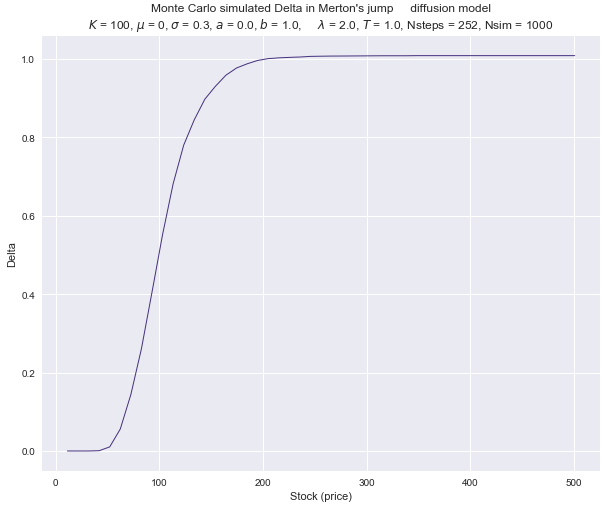

In [319]:
option_deltas = delta_of_Call_Option()
### Makes sense

### Vega
With respect to stock volatility. Volatility of jump size/ any particular correlations between vols is not considered.

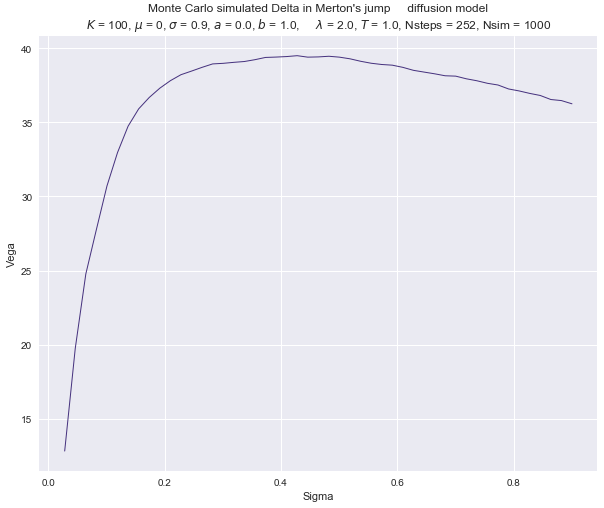

In [320]:
vector_Sigma = np.linspace(0.01,0.9,num=50)
def vega_of_Call_Option(vector_Sigma=vector_Sigma,K=100):
    delta_Sigma = vector_Sigma[1] - vector_Sigma[0]
    option_prices = []
    for sigma in vector_Sigma:
        np.random.seed(0)
        M,V, simulated_paths = jump_diffusion_simulation(sigma=sigma,hide=True)
        final_prices = simulated_paths[:,-1]
        A_t = [max([0,x-K]) for x in final_prices]
        # Compute mean, variance, standard deviation, skewness, excess kurtosis
        mean_At= np.mean(A_t)
        option_prices.append(mean_At)
    # Choose palette, figure size, and define figure axes
    sns.set(palette='viridis')
    plt.figure(figsize=(10,8))
    ax = plt.axes()
    option_vegas=np.diff(option_prices)/delta_Sigma
    # Plot the Monte Carlo simulated stock price paths
    jump_diffusion_vega = ax.plot(vector_Sigma[1:], option_vegas);

    # Make drawn paths thinner by decreasing line width
    plt.setp(jump_diffusion_vega, linewidth=1);

    # Set title (LaTeX notation) and x- and y- labels
    ax.set(title="Monte Carlo simulated Delta in Merton's jump \
    diffusion model\n$K$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, \
    $\lambda$ = {}, $T$ = {}, Nsteps = {}, Nsim = {}"\
           .format(K, mu, sigma, a,b, Lambda, T, Nsteps, Nsims), \
           xlabel='Sigma', ylabel='Vega')

    # Display figure in a Python environment
    plt.show()
    return option_vegas
option_deltas = vega_of_Call_Option()

### Gamma
Using finite difference approach

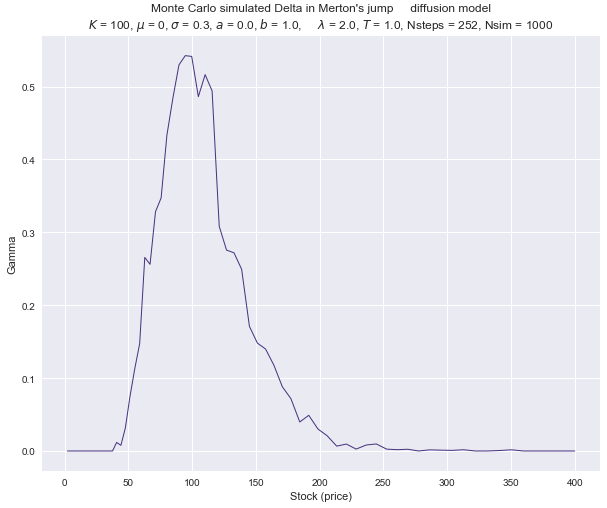

In [321]:
vector_S = [x**2 for x in np.linspace(1.0,20.0,num=75)]
def gamma_of_Call_Option(vector_S=vector_S,K=100):
    delta_S = np.diff(vector_S)
    option_prices = []
    for s0 in vector_S:
        np.random.seed(0)
        M,V, simulated_paths = jump_diffusion_simulation(S0=s0,hide=True)
        final_prices = simulated_paths[:,-1]
        A_t = [max([0,x-K]) for x in final_prices]
        # Compute mean, variance, standard deviation, skewness, excess kurtosis
        mean_At= np.mean(A_t)
        option_prices.append(mean_At)
    # Choose palette, figure size, and define figure axes
    sns.set(palette='viridis')
    plt.figure(figsize=(10,8))
    ax = plt.axes()
    option_deltas=np.diff(option_prices)/delta_S
    option_gammas = np.diff(option_deltas)/np.diff(delta_S)
    # Plot the Monte Carlo simulated stock price paths
    jump_diffusion_gamma = ax.plot(vector_S[2:], option_gammas);

    # Make drawn paths thinner by decreasing line width
    plt.setp(jump_diffusion_gamma, linewidth=1);

    # Set title (LaTeX notation) and x- and y- labels
    ax.set(title="Monte Carlo simulated Delta in Merton's jump \
    diffusion model\n$K$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, \
    $\lambda$ = {}, $T$ = {}, Nsteps = {}, Nsim = {}"\
           .format(K, mu, sigma, a,b, Lambda, T, Nsteps, Nsims), \
           xlabel='Stock (price)', ylabel='Gamma')

    # Display figure in a Python environment
    plt.show()
    return option_gammas
gammas = gamma_of_Call_Option(vector_S=vector_S)

### Change in Jump Size Distribution
Uniform and Normal

#### Uniform distribution

Currently k = E[Y-1] = .0323 

mu = (b-a)/2; sigma = (b-a)^2/12

A look at the compound process

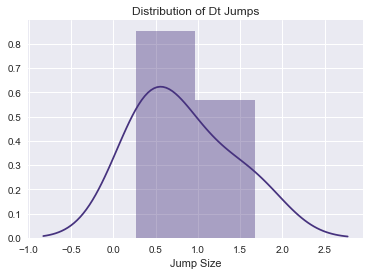

In [326]:
# b=4.0
# plt.plot(jump_process(Lambda=Lambda,a=a,b=b,T=T,Nsteps=Nsteps,Nsims=Nsims))
num_jumps = stats.poisson(2.0*1/252).rvs(252)
delta_jumps = [np.random.uniform(0,2.004,jumps) if jumps > 0 else 1 for jumps in num_jumps ]
delta_jumps = [y for y in [np.prod(x) for x in delta_jumps] if y != 1]

ax = sns.distplot( delta_jumps )
ax.set_title("Distribution of Dt Jumps")
ax.set_xlabel("Jump Size")


Total running time: 11649.00 ms
K (expected Jump) 0.20%


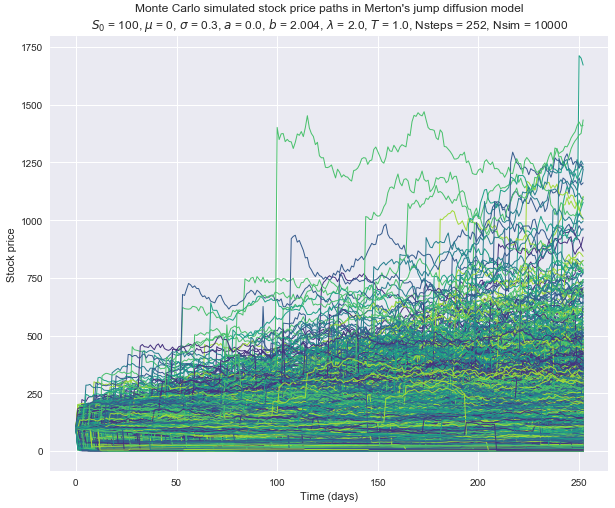

Total running time: 173953065.00 ms
Merton's Jump Diffusion Model
-----------------------------
Theoretical Moments
-----------------------------
Mean (M)             100.4008
Variance (V)       11460.0544

Monte Carlo Estimates
-----------------------------
Mean                 100.8938
Variance           11812.1936
Standard deviation   108.6839
Skewness               3.6285
Excess kurtosis       25.6649

Confidence interval, Mean
-----------------------------
Alpha                    0.05
Lower bound           98.7636
Upper bound          103.0239
========END RUN========




In [327]:
# USER INPUT
S0=100
alpha=0.05
Nsims = 10000
Nsteps=252
sigma=0.3
mu=0
T=1.0
Lambda=2.0#/Nsteps
b=2.004 #/np.sqrt(Nsteps) #Percentage Jump
a=0.0

def uniform_jump_process(Lambda,a,b,T,Nsteps,Nsims):
    
    """ Simulate compound poisson process with Lambda & Lognormal Dist 
        
        Parameters
        ==========
        
        Lambda (float): Intensity of Poisson Process i.e. Num expected jumps in T period
        a (float) : mu of underlying normal distribution
        b (float) : variance of underlying normal distribution (This should be scaled for t)
        
        T (float) : Period over which Jump process occurs
        Nsteps (int) : Number of increments 
        Nsims (int) : Number of MC simulations 
        
        Returns
        ========
        compound poission process (list) : 1 d array of the resultant 
            Y(u) = I if II = 0; Y(r) = fly _, Y, for n 2 I
    
        References
        ==========
        http://www.people.hbs.edu/rmerton/optionpricingwhenunderlingstock.pdf
        https://www.lpsm.paris/pageperso/tankov/tankov_voltchkova.pdf
        
    """
    delta_t = T/Nsteps
    num_jumps=np.random.poisson(Lambda*delta_t, size=Nsims)
    delta_jumps = [np.random.uniform(a,b,jumps) if jumps > 0 else 1 for jumps in num_jumps ]
    """ Return  Y(n) as per Merton 1976 Pg 129 --- (3)"""
    return [np.prod(x) for x in delta_jumps]

def uniform_jump_diffusion_simulation(mu=mu,sigma=sigma,T=T,S0=S0,a=a,b=b,
                              Lambda=Lambda,Nsteps=Nsteps,Nsims=Nsims,hide=False):
    """ Simulate stock price accounting for large jumps in short periods i.e. 'jump stochastic process'
    
    Parameters
    ==========
    
    S0 (float): Initial Stock Price
    sigma (float) : instantaneous variance of the return
    mu (float) : instaneous expected return of S
 
    Lambda (float): Intensity of Poisson Process i.e. Num expected jumps in T period
    a (float) : mu of underlying normal distribution
    b (float) : variance of underlying normal distribution (This should be scaled for t)

    T (float) : Period over which Jump process occurs
    Nsteps (int) : Number of increments 
    Nsims (int) : Number of MC simulations 

    
    """

    tic=time.time()
           
    delta_t = T/Nsteps

    simulated_paths = np.ones((Nsims,Nsteps+1))
    simulated_paths[:,0] = S0
    
    mean_Y = (a+b)/2
    variance_Y = (b-a)**2/12
    
    KL = Lambda*(mean_Y - 1)

    M = S0 * np.exp(mu*T + Lambda*T*(mean_Y-1))
    V = S0**2 * (np.exp((2*mu + sigma**2)*T \
        + Lambda*T*(variance_Y + mean_Y**2 - 1)) \
        - np.exp(2*mu*T + 2*Lambda*T*(mean_Y - 1)))
    np.random.seed(0)
    for i in range(Nsteps):
        simulated_paths[:,i+1] = generate_asset_price(simulated_paths[:,i],sigma,mu,delta_t,Nsims,KL)*\
        uniform_jump_process(Lambda=Lambda,a=a,b=b,T=T,Nsteps=Nsteps,Nsims=Nsims)
    toc = time.time()
    elapsed_time = toc - tic
    if not hide:
        print('Total running time: {:.2f} ms'.format(elapsed_time*1000))
        print('K (expected Jump) {:>.2f}%'.format((mean_Y-1.0)*100))
    return M,V,simulated_paths

M,V, simulated_paths = uniform_jump_diffusion_simulation()
final_prices = simulated_paths[:,-1]

# Compute mean, variance, standard deviation, skewness, excess kurtosis
mean_S = np.mean(final_prices)
var_S = np.var(final_prices)
std_S = np.std(final_prices)
skew_S = stats.skew(final_prices)
kurt_S = stats.kurtosis(final_prices)

# Choose palette, figure size, and define figure axes
sns.set(palette='viridis')
plt.figure(figsize=(10,8))
ax = plt.axes()

# Generate t, the time variable on the abscissae
t = np.linspace(0, T, Nsteps+1) * Nsteps

# Plot the Monte Carlo simulated stock price paths
jump_diffusion = ax.plot(t, simulated_paths.transpose());

# Make drawn paths thinner by decreasing line width
plt.setp(jump_diffusion, linewidth=1);

# Set title (LaTeX notation) and x- and y- labels
ax.set(title="Monte Carlo simulated stock price paths in Merton's jump \
diffusion model\n$S_0$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, \
$\lambda$ = {}, $T$ = {}, Nsteps = {}, Nsim = {}"\
       .format(S0, mu, sigma, a,b, Lambda, T, Nsteps, Nsims), \
       xlabel='Time (days)', ylabel='Stock price')

# Display figure in a Python environment
plt.show()

# Calculate confidence interval for the mean
ci_low = mean_S - std_S/np.sqrt(Nsims)*stats.norm.ppf(1-0.5*alpha)
ci_high = mean_S + std_S/np.sqrt(Nsims)*stats.norm.ppf(1-0.5*alpha)

# Time and print the elapsed time
toc = time.time()
elapsed_time = toc - tic
print('Total running time: {:.2f} ms'.format(elapsed_time*1000))
#print('Mean {:>24.4f}'.format(mean_S))
#print('Variance {:>20.4f}'.format(var_S))
#print('Standard deviation {:>10.4f}'.format(std_S))

print("Merton's Jump Diffusion Model")
print('-----------------------------')
print('Theoretical Moments')
print('-----------------------------')
print('Mean (M){:>21.4f}'.format(M))
print('Variance (V){:>17.4f}'.format(V))
print('\nMonte Carlo Estimates')
print('-----------------------------')
print('Mean {:>24.4f}'.format(mean_S))
print('Variance {:>20.4f}'.format(var_S))
print('Standard deviation {:>10.4f}'.format(std_S))
print('Skewness {:>20.4f}'.format(skew_S))
print('Excess kurtosis {:>13.4f}'.format(kurt_S))
print('\nConfidence interval, Mean')
print('-----------------------------')
print('Alpha {:>23.2f}'.format(alpha))
print('Lower bound {:>17.4f}'.format(ci_low))
print('Upper bound {:>17.4f}'.format(ci_high))
print("========END RUN========")
print("\n")

In [ ]:
### A LOT MORE VARIANCE --- MC ESTIMATES VARY A LOT MORE (FOR SAME NUM SIMS)

#### Using Normal Distribution
(Work in Progress)

### A look at MC variance Reduction

Use of Antithetic variables

Lets try reducing the variance of a jump-diffusion process with uniform jump sizes.

Total running time: 12241.00 ms
K (expected Jump) 0.20%


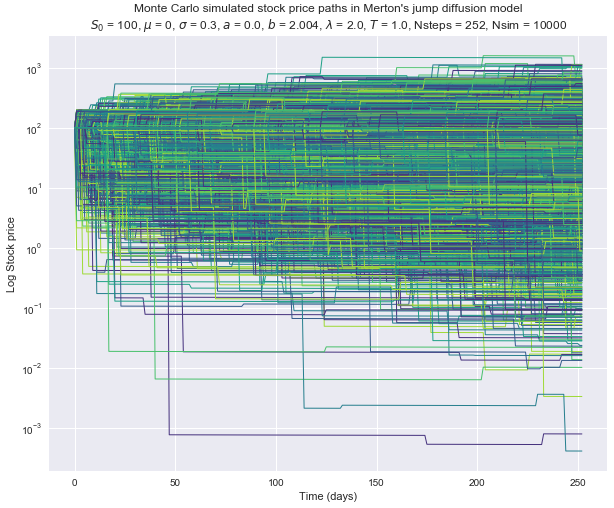

Total running time: 173997985.00 ms
Merton's Jump Diffusion Model
-----------------------------
Theoretical Moments
-----------------------------
Mean (M)             100.4008
Variance (V)       11460.0544

Monte Carlo Estimates
-----------------------------
Mean                  95.6789
Variance            8511.0938
Standard deviation    92.2556
Skewness               2.9356
Excess kurtosis       18.3084

Confidence interval, Mean
-----------------------------
Alpha                    0.05
Lower bound           93.8707
Upper bound           97.4871
========END RUN========




In [328]:
# USER INPUT
S0=100
alpha=0.05
Nsims = 10000
Nsteps=252
sigma=0.3
mu=0
T=1.0
Lambda=2.0#/Nsteps
b=2.004 #/np.sqrt(Nsteps) #Percentage Jump
a=0.0

flatten = lambda l: [item for sublist in l for item in sublist]


def antithetic_generate_asset_price(S0,sigma,mu,T,Nsims,KL):
    """ Standard difussion --- Brownian motion for asset price 
        
        Parameters
        ==========
        
        S0 (float): Initial Stock Price
        sigma (float) : instantaneous variance of the return
        mu (float) : instaneous expected return of S
        
        T (float) : Period over which process occurs
        Nsims (int) : Number of MC simulations
        KL (float) : k is the expectation operator over the random variable Y,KL = Lambda*k, if Lambda = 0, then K = 0
    
        References
        ==========
        http://www.people.hbs.edu/rmerton/optionpricingwhenunderlingstock.pdf
        https://www.lpsm.paris/pageperso/tankov/tankov_voltchkova.pdf
    
    """
    antithetics = np.random.normal(0,1.0,int(Nsims/2))
    antithetics = flatten([antithetics,antithetics*-1])
    return S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) *  - T*KL)

def antithetic_uniform_jump_process(Lambda,a,b,T,Nsteps,Nsims):
    
    """ Simulate compound poisson process with Lambda & Lognormal Dist 
        
        Parameters
        ==========
        
        Lambda (float): Intensity of Poisson Process i.e. Num expected jumps in T period
        a (float) : mu of underlying normal distribution
        b (float) : variance of underlying normal distribution (This should be scaled for t)
        
        T (float) : Period over which Jump process occurs
        Nsteps (int) : Number of increments 
        Nsims (int) : Number of MC simulations 
        
        Returns
        ========
        compoind poission process (list) : 1 d array of the resultant 
            Y(u) = I if II = 0; Y(/r) = fly _, Y, for n 2 I
    
        References
        ==========
        http://www.people.hbs.edu/rmerton/optionpricingwhenunderlingstock.pdf
        https://www.lpsm.paris/pageperso/tankov/tankov_voltchkova.pdf
        
    """
    delta_t = T/Nsteps
    num_jumps=np.random.poisson(Lambda*delta_t, size=Nsims)
    sizes = np.random.uniform(a,b,Nsims)
    delta_jumps = [ [sizes[j],b-sizes[j]] if num_jumps[j] > 0 else [1,1] for j in range(len(num_jumps)/2) ]
    delta_jumps=flatten(delta_jumps)
    """ Return  Y(n) as per Merton 1976 Pg 129 --- (3)"""
    return [np.prod(x) for x in delta_jumps]

def antithetic_uniform_jump_diffusion_simulation(mu=mu,sigma=sigma,T=T,S0=S0,a=a,b=b,
                              Lambda=Lambda,Nsteps=Nsteps,Nsims=Nsims,hide=False):
    """ Simulate stock price accounting for large jumps in short periods i.e. 'jump stochastic process'
    
    Parameters
    ==========
    
    S0 (float): Initial Stock Price
    sigma (float) : instantaneous variance of the return
    mu (float) : instaneous expected return of S
 
    Lambda (float): Intensity of Poisson Process i.e. Num expected jumps in T period
    a (float) : mu of underlying normal distribution
    b (float) : variance of underlying normal distribution (This should be scaled for t)

    T (float) : Period over which Jump process occurs
    Nsteps (int) : Number of increments 
    Nsims (int) : Number of MC simulations 

    
    """
    np.random.seed(0)
    tic=time.time()
           
    delta_t = T/Nsteps

    simulated_paths = np.ones((Nsims,Nsteps+1))
    simulated_paths[:,0] = S0
    
    mean_Y = (a+b)/2
    variance_Y = (b-a)**2/12
    
    KL = Lambda*(mean_Y - 1)

    M = S0 * np.exp(mu*T + Lambda*T*(mean_Y-1))
    V = S0**2 * (np.exp((2*mu + sigma**2)*T \
        + Lambda*T*(variance_Y + mean_Y**2 - 1)) \
        - np.exp(2*mu*T + 2*Lambda*T*(mean_Y - 1)))

    for i in range(Nsteps):
        simulated_paths[:,i+1] = antithetic_generate_asset_price(simulated_paths[:,i],sigma,mu,delta_t,Nsims,KL)*\
        antithetic_uniform_jump_process(Lambda=Lambda,a=a,b=b,T=T,Nsteps=Nsteps,Nsims=Nsims)
    toc = time.time()
    elapsed_time = toc - tic
    if not hide:
        print('Total running time: {:.2f} ms'.format(elapsed_time*1000))
        print('K (expected Jump) {:>.2f}%'.format((mean_Y-1.0)*100))
    return M,V,simulated_paths

M,V, simulated_paths = antithetic_uniform_jump_diffusion_simulation()
final_prices = simulated_paths[:,-1]

# Compute mean, variance, standard deviation, skewness, excess kurtosis
mean_S = np.mean(final_prices)
var_S = np.var(final_prices)
std_S = np.std(final_prices)
skew_S = stats.skew(final_prices)
kurt_S = stats.kurtosis(final_prices)

# Choose palette, figure size, and define figure axes
sns.set(palette='viridis')
plt.figure(figsize=(10,8))
ax = plt.axes()

# Generate t, the time variable on the abscissae
t = np.linspace(0, T, Nsteps+1) * Nsteps

# Plot the Monte Carlo simulated stock price paths
jump_diffusion = ax.plot(t,simulated_paths.transpose());

# Make drawn paths thinner by decreasing line width
plt.setp(jump_diffusion, linewidth=1);

# Set title (LaTeX notation) and x- and y- labels
ax.set(title="Monte Carlo simulated stock price paths in Merton's jump \
diffusion model\n$S_0$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, \
$\lambda$ = {}, $T$ = {}, Nsteps = {}, Nsim = {}"\
       .format(S0, mu, sigma, a,b, Lambda, T, Nsteps, Nsims), \
       xlabel='Time (days)', ylabel='Log Stock price')
ax.set_yscale('log')
# Display figure in a Python environment
plt.show()

# Calculate confidence interval for the mean
ci_low = mean_S - std_S/np.sqrt(Nsims)*stats.norm.ppf(1-0.5*alpha)
ci_high = mean_S + std_S/np.sqrt(Nsims)*stats.norm.ppf(1-0.5*alpha)

# Time and print the elapsed time
toc = time.time()
elapsed_time = toc - tic
print('Total running time: {:.2f} ms'.format(elapsed_time*1000))
#print('Mean {:>24.4f}'.format(mean_S))
#print('Variance {:>20.4f}'.format(var_S))
#print('Standard deviation {:>10.4f}'.format(std_S))

print("Merton's Jump Diffusion Model")
print('-----------------------------')
print('Theoretical Moments')
print('-----------------------------')
print('Mean (M){:>21.4f}'.format(M))
print('Variance (V){:>17.4f}'.format(V))
print('\nMonte Carlo Estimates')
print('-----------------------------')
print('Mean {:>24.4f}'.format(mean_S))
print('Variance {:>20.4f}'.format(var_S))
print('Standard deviation {:>10.4f}'.format(std_S))
print('Skewness {:>20.4f}'.format(skew_S))
print('Excess kurtosis {:>13.4f}'.format(kurt_S))
print('\nConfidence interval, Mean')
print('-----------------------------')
print('Alpha {:>23.2f}'.format(alpha))
print('Lower bound {:>17.4f}'.format(ci_low))
print('Upper bound {:>17.4f}'.format(ci_high))
print("========END RUN========")
print("\n")

There is some amount of variance reduction by using antithetic variables.

## TODOS:

* Investigate model behaviour in boundary cases, e.g. Large Sigma, Jump Intensity etc.

* Analyse variance further --- increasing sims seem to have minimal effect on variance reduction...suspect better management of Jump process could have a large effect 

* Analyse the case of normally distributed jump sizes. A double-exponential distribution is also investigated in many studies.

## Initial Workings

Below are my initial runs and analysis to understand/visualise the Diffusion and particularly the Jump process

### Analysing the Diffusion Process

In [169]:
def brownian_path(N):
    delta_t_sqrt = math.sqrt(1 / N)
    Z = np.random.randn(N)
    Z[0] = 0
    B = np.cumsum(delta_t_sqrt * Z)
    return B

N = 365
T = [x for x in range(N)]
B = brownian_path(365)

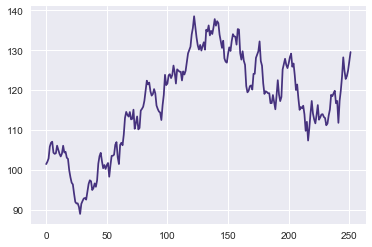

In [173]:
def generate_asset_price(S0,v,mu,T):
    """ Standard difussion --- Brownian motion for asset price """
    return S0 * np.exp((mu - 0.5 * sigma**2) * T + v * np.sqrt(T) * np.random.normal(0,1.0))
# USER INPUT
S0 = 100 # underlying price
v = 0.30 # vol of 20.76%
mu = 0.0 # mu
dt = 1.0/252 # 1 day
T = 1.0 # period end
n = int(T/dt) # number of steps

S_path=[]
S=S0 # starting price
for i in np.arange(1,n+1):
    S_t = generate_asset_price(S,sigma,mu,dt)
    S= S_t
    S_path.append(S_t)

plt.plot(S_path)

### Analysing the Compound Poisson Process

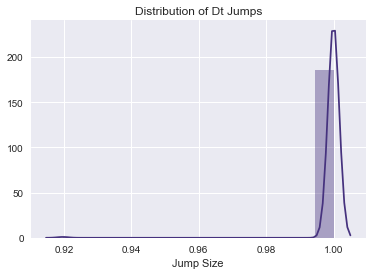

In [167]:
# b=4.0
# plt.plot(jump_process(Lambda=Lambda,a=a,b=b,T=T,Nsteps=Nsteps,Nsims=Nsims))
num_jumps = stats.poisson(2.0*1/252).rvs(252)
delta_jumps = [np.random.lognormal(0,0.4,jumps) if jumps > 0 else 1 for jumps in num_jumps ]
delta_jumps = [np.prod(x) for x in delta_jumps ]

ax = sns.distplot( delta_jumps )
ax.set_title("Distribution of Dt Jumps")
ax.set_xlabel("Jump Size")
#savefig("distribution_yearly_jumps.png", dpi=200 )

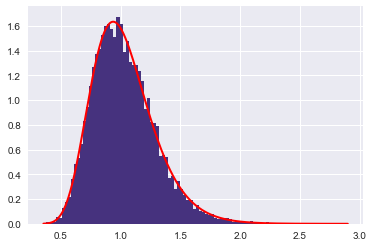

In [160]:
## A look at the underlying Lognormal Distribution Yj
# mean and standard deviation
mu, sigma = 0., 4.0*np.sqrt(1.0/252)
s = np.random.lognormal(mu, sigma, 10000)
count, bins, ignored = plt.hist(s, 100, normed=True, align='mid')
x = np.linspace(min(bins), max(bins), 100000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
       / (x * sigma * np.sqrt(2 * np.pi)))

plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.show()

In [103]:
def jump_process(Lambda,a,b,T,Nsteps,Nsims):
    
    """ Simulate compound poisson process with Lambda & Lognormal Dist 
        
        Parameters
        ==========
        
        Lambda (float): Intensity of Poisson Process i.e. Num expected jumps in T period
        a (float) : mu of underlying normal distribution
        b (float) : variance of underlying normal distribution
        
        T (float) : Period over which Jump process occurs
        Nsteps (int) : Number of increments 
        Nsims (int) : Number of MC simulations 
    
    """
    delta_t = T/Nsteps
    num_jumps=np.random.poisson(Lambda*delta_t, size=Nsims)
    delta_jumps = [np.random.lognormal(a,b,jumps) if jumps > 0 else 1 for jumps in num_jumps ]
    """ Return  Y(n) as per Merton 1976 Pg 129 --- (3)"""
    return [np.prod(x) for x in delta_jumps]

## References

#### JPM and General

http://www.people.hbs.edu/rmerton/optionpricingwhenunderlingstock.pdf

https://www.lpsm.paris/pageperso/tankov/tankov_voltchkova.pdf

http://www.columbia.edu/~sk75/MagSci02.pdf

http://www.columbia.edu/~sk75/HORM15002.pdf

https://www.quantstart.com/articles/Jump-Diffusion-Models-for-European-Options-Pricing-in-C

https://www.fh-vie.ac.at/var/em_plain_site/storage/original/application/c448c4a19a23724993b6fe3d8a7b9f2c.pdf

https://ionides.github.io/531w16/final_project/Project06/final_report.html

https://core.ac.uk/download/pdf/7354772.pdf

https://github.com/federicomariamassari/financial-engineering/blob/master/python-modules/jump_diffusion.py

https://github.com/federicomariamassari/financial-engineering/blob/master/handbook/01-merton-jdm.ipynb

https://github.com/CamDavidsonPilon/PyProcess

#### GBM

https://www.stat.berkeley.edu/~aldous/Research/Ugrad/ZY1.pdf

https://thequantmba.wordpress.com/2016/11/18/simulate-asset-price-using-geometric-brownian-motion-in-python/

http://landonjross.io/simulating-brownian-motion-in-python-with-numpy.html

#### Compound poisson process

https://en.wikipedia.org/wiki/Compound_Poisson_distribution

https://hal.archives-ouvertes.fr/hal-01228389/document

http://www.ntu.edu.sg/home/nprivault/MA5182/stochastic-calculus-jump-processes.pdf

http://connor-johnson.com/2014/11/08/compound-poisson-processes/

http://www.columbia.edu/~ks20/4703-Sigman/4703-07-Notes-PP-NSPP.pdf


#### Black Scholes & Approximations

https://www.quantstart.com/articles/European-Vanilla-Call-Put-Option-Pricing-with-Python
https://www.quantstart.com/articles/Jump-Diffusion-Models-for-European-Options-Pricing-in-C

#### Variance Reduction
https://statweb.stanford.edu/~owen/mc/Ch-var-basic.pdf


In [ ]:
# def generate_asset_price(S0,sigma,mu,T,Nsims,K):
#     """ Standard difussion --- Brownian motion for asset price """
#     return S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.normal(0,1.0,Nsims) -T*K)

# tic=time.time()
# # USER INPUT
# S0=100
# alpha=0.05
# Nsims = 50
# Nsteps=252
# sigma=0.3
# mu=0
# delta_t = 1.0/Nsteps
# T=1.0
# Lambda=2.0#/Nsteps
# b=4.0*np.sqrt(delta_t) #/np.sqrt(Nsteps) #Percentage Jump
# a=0.0
# KL = Lambda*(np.exp(b**2/2) - 1)

# simulated_paths = np.ones((Nsims,Nsteps+1))
# simulated_paths[:,0] = S0

# mean_Y = np.exp(a + 0.5*(b**2))
# variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)

# M = S0 * np.exp(mu*T + Lambda*T*(mean_Y-1))
# V = S0**2 * (np.exp((2*mu + sigma**2)*T \
#     + Lambda*T*(variance_Y + mean_Y**2 - 1)) \
#     - np.exp(2*mu*T + 2*Lambda*T*(mean_Y - 1)))

# for i in range(Nsteps):
#     simulated_paths[:,i+1] = generate_asset_price(simulated_paths[:,i],sigma,mu,delta_t,Nsims,KL)*\
#     jump_process(Lambda=Lambda,a=a,b=b,T=T,Nsteps=Nsteps,Nsims=Nsims)

In [ ]:
# # Populate the matrix with Nsim randomly generated paths of length Nsteps
# S=100
# alpha=0.05
# Nsim = 5
# Nsteps=252
# sigma=0.3
# mu=0
# Delta_t = 1.0/Nsteps
# T=1.0
# Lambda=2.0#/Nsteps
# b=4.0/np.sqrt(Nsteps)
# a=0.0

# tic=time.time()
# Poisson=np.random.poisson(Lambda*Delta_t, size=(Nsim,Nsteps))
# Z_1 = np.random.normal(mu, sigma, size=(Nsim,Nsteps))
# Z_2 = np.random.lognormal(a, b, size=(Nsim,Nsteps))

# simulated_paths = np.zeros((Nsim,Nsteps+1))
# simulated_paths[:,0] = S

# mean_Y = np.exp(a + 0.5*(b**2))
# variance_Y = np.exp(2*a + b**2) * (np.exp(b**2)-1)

# M = S * np.exp(mu*T + Lambda*T*(mean_Y-1))
# V = S**2 * (np.exp((2*mu + sigma**2)*T \
#     + Lambda*T*(variance_Y + mean_Y**2 - 1)) \
#     - np.exp(2*mu*T + 2*Lambda*T*(mean_Y - 1)))

# # for i in range(Nsteps):
# #     simulated_paths[:,i+1] = simulated_paths[:,i]*np.exp((mu
# #                            - sigma**2/2)*Delta_t + sigma*np.sqrt(Delta_t) \
# #                            * Z_1[:,i] + a*Poisson[:,i] \
# #                            + np.sqrt(b**2) * np.sqrt(Poisson[:,i]) \
# #                            * Z_2[:,i])
# for i in range(Nsteps):
#     simulated_paths[:,i+1] = simulated_paths[:,i]*np.exp((mu 
#                              - sigma**2/2)*Delta_t + sigma*np.sqrt(Delta_t) \
#                              * Z_1[:,i]\
#                              -Lambda*(np.exp(b**2/2) - 1)*Delta_t)* Poisson[:,i]



# # Single out array of simulated prices at maturity T
# final_prices = simulated_paths[:,-1]

# # Compute mean, variance, standard deviation, skewness, excess kurtosis
# mean_jump = np.mean(final_prices)
# var_jump = np.var(final_prices)
# std_jump = np.std(final_prices)
# skew_jump = stats.skew(final_prices)
# kurt_jump = stats.kurtosis(final_prices)

# # Calculate confidence interval for the mean
# ci_low = mean_jump - std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)
# ci_high = mean_jump + std_jump/np.sqrt(Nsim)*stats.norm.ppf(1-0.5*alpha)

# # Print statistics, align results
# print("Merton's Jump Diffusion Model")
# print('-----------------------------')
# print('Theoretical Moments')
# print('-----------------------------')
# print('Mean (M){:>21.4f}'.format(M))
# print('Variance (V){:>17.4f}'.format(V))
# print('\nMonte Carlo Estimates')
# print('-----------------------------')
# print('Mean {:>24.4f}'.format(mean_jump))
# print('Variance {:>20.4f}'.format(var_jump))
# print('Standard deviation {:>10.4f}'.format(std_jump))
# print('Skewness {:>20.4f}'.format(skew_jump))
# print('Excess kurtosis {:>13.4f}'.format(kurt_jump))
# print('\nConfidence interval, Mean')
# print('-----------------------------')
# print('Alpha {:>23.2f}'.format(alpha))
# print('Lower bound {:>17.4f}'.format(ci_low))
# print('Upper bound {:>17.4f}'.format(ci_high))

# # Choose palette, figure size, and define figure axes
# sns.set(palette='viridis')
# plt.figure(figsize=(10,8))
# ax = plt.axes()

# # Generate t, the time variable on the abscissae
# t = np.linspace(0, T, Nsteps+1) * Nsteps

# # Plot the Monte Carlo simulated stock price paths
# jump_diffusion = ax.plot(t, simulated_paths.transpose());

# # Make drawn paths thinner by decreasing line width
# plt.setp(jump_diffusion, linewidth=1);

# # Set title (LaTeX notation) and x- and y- labels
# ax.set(title="Monte Carlo simulated stock price paths in Merton's jump \
# diffusion model\n$S_0$ = {}, $\mu$ = {}, $\sigma$ = {}, $a$ = {}, $b$ = {}, \
# $\lambda$ = {}, $T$ = {}, Nsteps = {}, Nsim = {}"\
#        .format(S, mu, sigma, a,b, Lambda, T, Nsteps, Nsim), \
#        xlabel='Time (days)', ylabel='Stock price')

# # Display figure in a Python environment
# plt.show()

# # Time and print the elapsed time
# toc = time.time()
# elapsed_time = toc - tic
# print('Total running time: {:.2f} ms'.format(elapsed_time*1000))
# print(mean_Y)

Interesting (Wolfram)

https://demonstrations.wolfram.com/DistributionOfReturnsFromMertonsJumpDiffusionModel/